In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_path = 'output_data/btes_base_case_orca_price_taker/'
file_names = [f for f in os.listdir(data_path) if f.endswith('.pickle')]

In [3]:
def get_btes_investment(component_results):
    """
    Get capital expenditure for BTES, i.e. sum of discharge, charge and energy store investment
    """
    btes_investment = 0
    for comp in [('Link','BTES_charger'), ('Link','BTES_discharger'), ('Store','granite')]:
        btes_investment += component_results[component_results.index == comp]['Capital Expenditure [$]'].values[0]
    return btes_investment

In [4]:
x, y = [], []

for file in file_names:
    with open(os.path.join(data_path, file), 'rb') as f:
        data = pickle.load(f)
        case_data = data['case results']

        cost = case_data['objective [$]'].values[-1]

        btes_cost = (file.split('_')[-1].split('.')[0])
        x.append(btes_cost)
        
        # Normalize by investment in BTES
        comp_results = data['component results']
        btes_investment = get_btes_investment(comp_results)

        hours = len(data['time results'])
        cost = cost / btes_investment / hours
        y.append(cost)

Text(0.5, 1.0, 'BTES price taker in natural gas based system')

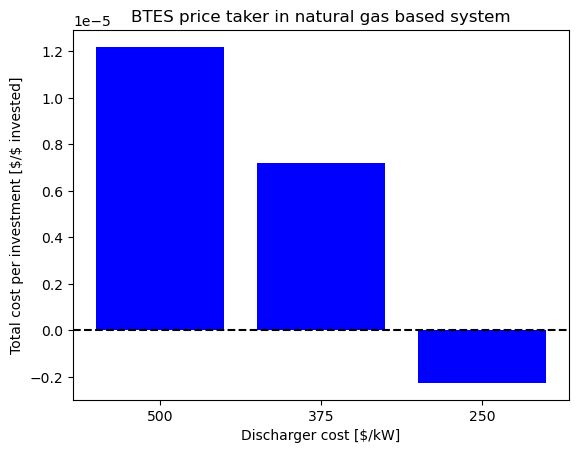

In [5]:
# Plot the data
# Sort x and y by y in descending order
x, y = zip(*sorted(zip(x, y), key=lambda x: x[1], reverse=True))
for i, cost in enumerate(y):
    plt.bar(x[i], cost, color='blue')
# Dashed horzontal line at 0
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Discharger cost [$/kW]')
plt.ylabel('Total cost per investment [\$/\$ invested]')
plt.title('BTES price taker in natural gas based system')

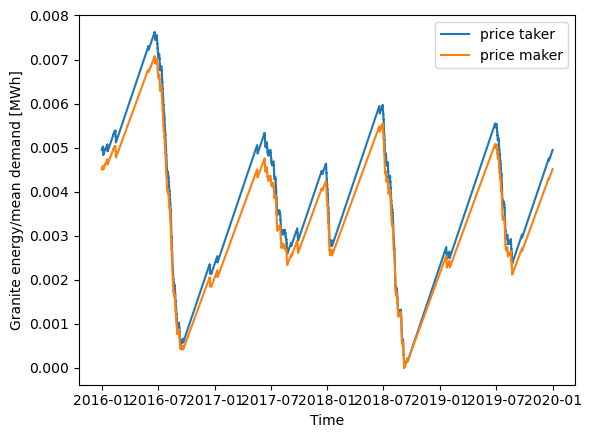

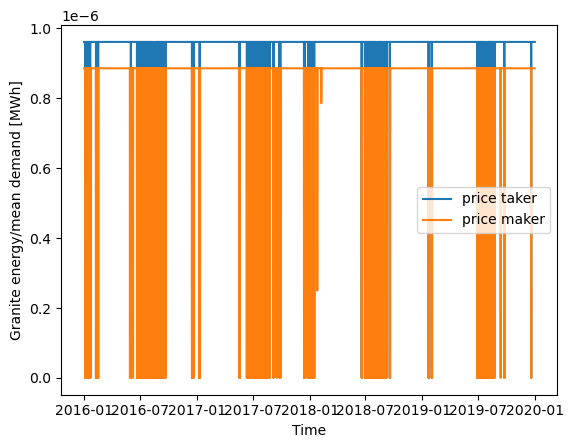

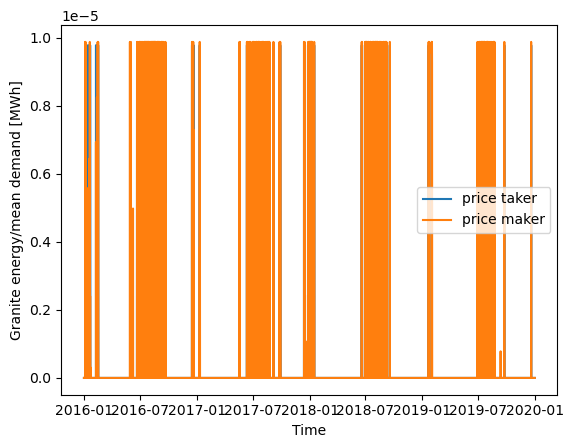

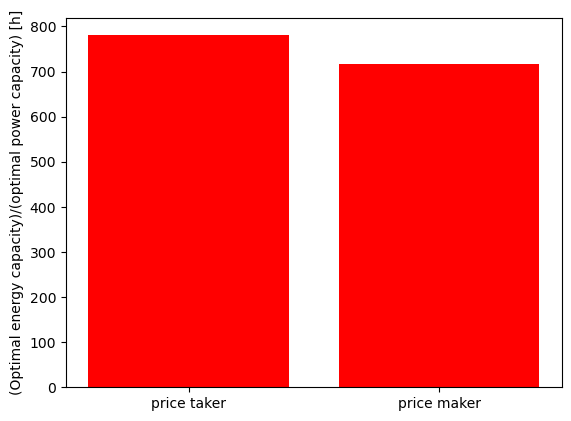

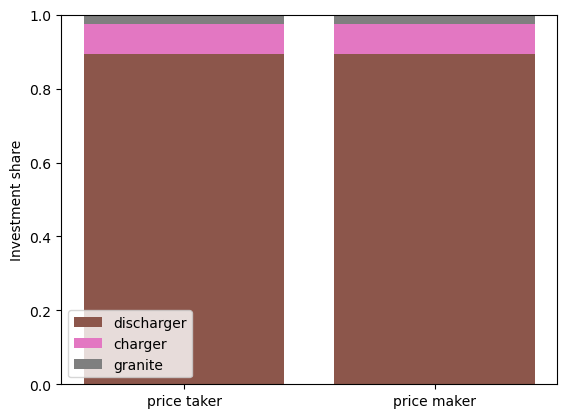

In [20]:
f1 = 'output_data/btes_base_case_orca_price_taker/btes_output_price_taker_base_BTES_discharger_250.pickle'
f2 = 'output_data/btes_base_case_orca/btes_output.pickle'

x2 = ['price taker', 'price maker']
h, inv = [], []

for time_curve in ['granite e', 'BTES_charger dispatch', 'BTES_discharger dispatch']:
    plt.figure()
    for filename in [f1, f2]:
        with open(filename, 'rb') as f:
            data = pickle.load(f)

            component_results = data['component results']
            # Get optimal capacity for BTES_discharger and granite
            granite = component_results[component_results.index == ('Store', 'granite')]
            discharger = component_results[component_results.index == ('Link', 'BTES_discharger')]
            charger = component_results[component_results.index == ('Link', 'BTES_charger')]

            if time_curve == 'granite e':
                granite_opt_cap = granite['Optimal Capacity [MW]'].values[0]
                discharger_opt_cap = discharger['Optimal Capacity [MW]'].values[0] 
                duration = granite_opt_cap / discharger_opt_cap

                h.append(duration)

            # Get investment
            inv.append([discharger['Capital Expenditure [$]'].values[0], charger['Capital Expenditure [$]'].values[0], granite['Capital Expenditure [$]'].values[0]])

            # Time results
            time_results = data['time results']
            time_var = time_results[time_curve]
            btes_invest = get_btes_investment(component_results)
            time_var = time_var / btes_invest
            if 'price_taker' in filename:
                label = 'price taker'
            else:
                label = 'price maker'
            plt.plot(time_var, label=label)

    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Granite energy/mean demand [MWh]')

plt.figure()
plt.bar(x2, h, color='red')
plt.ylabel('(Optimal energy capacity)/(optimal power capacity) [h]')

plt.figure()
# Make a stacked bar plot for each list in inv
btes_labels = ['discharger', 'charger', 'granite']
for bar in inv:
    bottom = 0
    for cost in bar:
        plt.bar(x2, cost/np.sum(bar), bottom=bottom, label=btes_labels[bar.index(cost)])
        bottom += cost/np.sum(bar)
plt.ylabel('Investment share')
plt.ylim(0, 1)
# Ger unique handles and labels for the legend, each label only once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())